In [34]:
# %pip install qubovert
# %pip install qiskit-aer
# %pip install qiskit
# %pip install pylatexenc
import json
import numpy as np
from datetime import datetime
from qubovert import QUBO, boolean_var
from qubovert.sim import anneal_qubo
from qubovert.utils import qubo_to_matrix
import random
import math
import pandas as pd

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

In [35]:
def filter_dates_before(input_dict, specified_date):
    """
    Filters the input dictionary to include only entries with dates before the specified date.

    Parameters:
    input_dict (dict): A dictionary with dates as keys in 'yyyy-mm-dd' format.
    specified_date (str): A date in 'yyyy-mm-dd' format to filter the dictionary.

    Returns:
    dict: A new dictionary containing only the entries with dates before the specified date.
    """
    if specified_date is None:
        return input_dict
    # Convert the specified date string to a datetime object
    specified_date_obj = datetime.strptime(specified_date, '%Y-%m-%d')
    
    # Create a new dictionary to hold the filtered results
    filtered_dict = {}
    
    # Iterate through the input dictionary
    for date_str, data in input_dict.items():
        # Convert the date string to a datetime object
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        
        # Check if the date is before the specified date
        if date_obj < specified_date_obj:
            filtered_dict[date_str] = data
            
    return filtered_dict

In [36]:
def read_input_file(input_file_name:str,
                    date_limit:str=None,
                    max_assets:int=None):
    '''Given a file, it returns the data related to it,
    ignoring data before `date_limit`
    '''
    with open(input_file_name, 'r') as file:
        data = json.load(file)
    
    ######################
    # DATA PREPROCESSING #
    ######################


    # Select only `max_assets` at random (for debuggin purposes)
    if max_assets:
        asset_names = list(data['assets'].keys())
        selected_asset_names = random.sample(asset_names, max_assets)
        
        for a in list(data['assets'].keys()):
            if a not in selected_asset_names:
                data['assets'].pop(a)


    # Filter out all assets with a number of history items different than the trend (i.e. 751)
    # We recognize that this approach works well only in cases where the number of outliers is reduced
    # as in this case (9 out of ~900 assets).

    filtered_data = {key:data[key] for key in ['evaluation_date']}
    filtered_data['assets'] = {}
    for a in data['assets']:
        if len(data['assets'][a]['history']) == 751:
            filtered_data['assets'][a] = data['assets'][a]

    data = filtered_data
    
    # Filter by date
    for a in data['assets']:
        # print(a)
        data['assets'][a]['history'] = filter_dates_before(data['assets'][a]['history'], date_limit)

    
    return  data


In [37]:
data = read_input_file("../eth_hackathon/input_one_day.json", max_assets=5, date_limit="2022-8-15")

In [38]:
def covariance_matrix(data):
    '''Returns the covariance matrix of the assets in `data`
    using history up to date `date_limit`'''

    assets = list(data['assets'].keys())
    # number of history elements (assumed to be equal for all assets)
    num_history_dates = len(data['assets'][assets[0]]['history'])
    # print(num_history_dates)
    # number of assets we are taking into account
    N_considered_assets = len(data['assets'])

    # Each row of assets_matrix represents a variable, and each column a single observation of all those variables.
    assets_matrix = np.empty((N_considered_assets, num_history_dates))

    for i, asset in enumerate(assets):
        history = data['assets'][asset]['history']
        ##TODO add filtering by date
        assets_matrix[i, :] = list(history.values())

    return np.corrcoef(assets_matrix)


In [39]:
cvm = covariance_matrix(data)


In [ ]:

# model = QUBO()
# P = 0
# # bool_vars = np.zeros_like(cvm).tolist()

# triui = np.triu_indices_from(cvm, k=1)
# for k in range(len(triui[0])):
#     i = triui[0][k]
#     j = triui[1][k]
#     # bool_vars[i][j] = boolean_var(f'x{i}_{j}')
#     var = boolean_var(f'x_{i}_{j}')
#     model += var * cvm[i][j]


# portfolio_size = 6

# # add slack variables to implement constraint
# k = math.ceil(math.log2(portfolio_size//2))
# s_variables = [boolean_var(f's_{i}_s') for i in range(k)]
# tmp_model = QUBO()
# for i in range(len(s_variables)):
#     tmp_model+= s_variables[i] * (2 ** i)

# model+= P*(tmp_model - portfolio_size//2)**2

# solution = anneal_qubo(model, num_anneals=10).best




5


In [ ]:
tot_num_assets = cvm.shape[0]
model = QUBO()
names = [f"x_{i}" for i in range(tot_num_assets)]

x = []
for n in range(tot_num_assets):
    # print(n)
    x.append([])
    for i in range(2):
        x[n].append(boolean_var(f'x{n}_{i}'))
for t in range(2):
    temp_table_t = QUBO()
    for i, nomei in enumerate(names):
        for j, nomej in enumerate(names):
            if np.isnan(cvm[i][j]):
                continue
            temp_table_t += (cvm[i][j] * x[i][t] * x[j][t])
    model += temp_table_t

    # print(temp_table_t)


penalty = QUBO()
P1 = 3
# P1=50
# each person must sit at exactly 1 table
for i, name in enumerate(names):
    temp = QUBO()
    for t in range(2):
        temp += x[i][t]
    penalty += P1*(1 - temp)**2

P2 = 5

# P2=50
# each table must host exactly 5 people
for t in range(4):
    temp = QUBO()
    for i, name in enumerate(names):
        temp += x[i][t]
    penalty += P2*(5 - temp)**2

model -= penalty

model = -model

In [41]:
def get_selected_assets(data, sol):
    '''Given the solution of the optimization,
    it returns a dataset with name and history of the 
    selected assetes'''

    asset_names = list(data['assets'].keys())
    def parse_bool_var(x):
        name, i, j = x.split('_')
        if name == 'x':
            return int(i), int(j)
        return None, None 
    
    selected_assets_ids = ()
    for x in sol.state:
        if sol.state[x] == 1:
            i, j = parse_bool_var(x)
            if i is not None and j is not None:
                selected_assets_ids = (*selected_assets_ids, i, j)
    
    selected_assets = {asset_names[i]: data['assets'][asset_names[i]] for i in selected_assets_ids}

    with open('selected_assets.json', 'w') as fp:
        json.dump(selected_assets, fp)
    return selected_assets

sel_assets = get_selected_assets(data, solution)
print(sel_assets.keys())

dict_keys([])


{('x_0_1',): np.float64(0.10751862654691208), ('x_0_2',): np.float64(0.6350781899652945), ('x_0_3',): np.float64(0.06260388771930527), ('x_0_4',): np.float64(0.2648917940391533), ('x_1_2',): np.float64(0.3538360230713804), ('x_1_3',): np.float64(0.5563999780892313), ('x_1_4',): np.float64(0.41572224303101735), ('x_2_3',): np.float64(0.49180107870625295), ('x_2_4',): np.float64(0.5931043404179153), ('x_3_4',): np.float64(0.7948062244731188)}
10
[('ZIIIIIIIII', np.float64(0.10751862654691208))]
[('ZIIIIIIIII', np.float64(0.10751862654691208)), ('IZIIIIIIII', np.float64(0.6350781899652945))]
[('ZIIIIIIIII', np.float64(0.10751862654691208)), ('IZIIIIIIII', np.float64(0.6350781899652945)), ('IIZIIIIIII', np.float64(0.06260388771930527))]
[('ZIIIIIIIII', np.float64(0.10751862654691208)), ('IZIIIIIIII', np.float64(0.6350781899652945)), ('IIZIIIIIII', np.float64(0.06260388771930527)), ('IIIZIIIIII', np.float64(0.2648917940391533))]
[('ZIIIIIIIII', np.float64(0.10751862654691208)), ('IZIIIIIIII

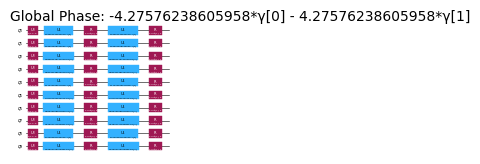

In [46]:
# np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})
def qubo_to_ising(model: QUBO):
    qubo = model.to_qubo()
    print(model)
    qubo_mat_dim = qubo.num_binary_variables
    # np_qubo = np.zeros((qubo_mat_dim,qubo_mat_dim))

    pauli_list = []
    # Z = ZGate().to_matrix()
    # HC = np.zeros_like(np_qubo)
    print(qubo_mat_dim)
    for i in range(qubo_mat_dim):
        for j in range(qubo_mat_dim):
            if (qubo[i,j] == 0):
                continue
            
            s = ['I' for i in range(qubo_mat_dim)]
            s[i] = 'Z'
            s[j] = 'Z'
            pauli_list.append((''.join(s), qubo[i,j]))
            print(pauli_list)
    HC = SparsePauliOp.from_list(pauli_list)
    ansatz = QAOAAnsatz(HC, reps=2)
    return ansatz, HC


# qubo_to_ising(model).decompose(reps=3).draw('mpl', scale=0.2, fold=200)
ansatz, cost_hamiltoniana = qubo_to_ising(model)
# ansatz.measure_all()
# ansatz.draw('mpl')
ansatz.decompose(reps=3).draw('mpl', scale=0.2, fold=200)
# ansatz.parameters


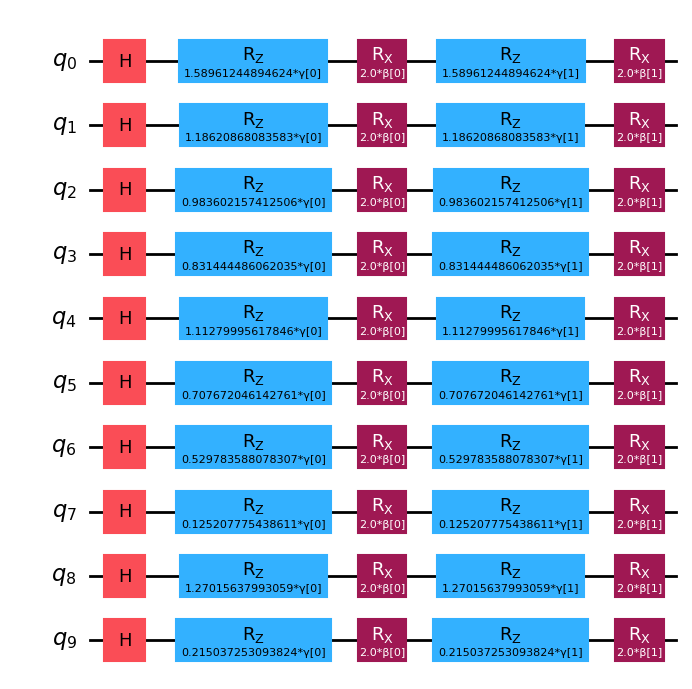

In [43]:
# from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Backend
backend= AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(ansatz)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [44]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [45]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'